# The Computer Vision Service

Azure's [Computer Vision](https://azure.microsoft.com/en-us/services/cognitive-services/computer-vision/) service exposes a rich API featuring a plethora of ways to analyze images and extract information from them. The [`ComputerVisionClient`](https://docs.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-computervision/azure.cognitiveservices.vision.computervision.operations.computervisionclientoperationsmixin?view=azure-python#methods) class in the [Computer Vision SDK for Python](https://pypi.org/project/azure-cognitiveservices-vision-computervision/) provides an easy-to-use interface to the API. Let's use it to see the Computer Vision service in action. Start by creating a `ComputerVisionClient` instance. Replace `KEY` with a Computer Vision subscription key and `ENDPOINT` with a Computer Vision endpoint:

In [1]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials

client = ComputerVisionClient(ENDPOINT, CognitiveServicesCredentials(KEY))

Now load an image and use [`describe_image_in_stream`](https://docs.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-computervision/azure.cognitiveservices.vision.computervision.operations.computervisionclientoperationsmixin?view=azure-python#azure-cognitiveservices-vision-computervision-operations-computervisionclientoperationsmixin-describe-image-in-stream) to caption it:

a man riding a sand dune (53.8%)


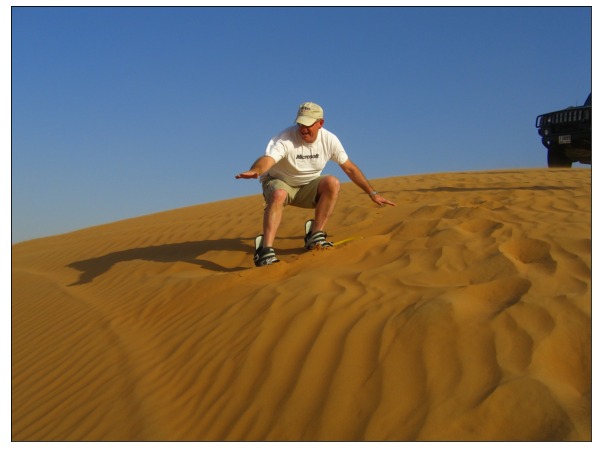

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

image = plt.imread('Data/dubai.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

with open('Data/dubai.jpg', mode='rb') as image:
    result = client.describe_image_in_stream(image)
    
    for caption in result.captions:
        print(f'{caption.text} ({caption.confidence:.1%})')

In addition to captioning images, the Computer Vision service can generate a list of keywords ("tags") describing an image’s content. One use for such tags is to make an image database searchable. Use the [`tag_image_in_stream`](https://docs.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-computervision/azure.cognitiveservices.vision.computervision.operations.computervisionclientoperationsmixin?view=azure-python#azure-cognitiveservices-vision-computervision-operations-computervisionclientoperationsmixin-tag-image-in-stream) method to tag the image:

In [3]:
with open('Data/dubai.jpg', mode='rb') as image:
    result = client.tag_image_in_stream(image)

    for tag in result.tags:
        print(f'{tag.name} ({tag.confidence:.1%})')

dune (99.5%)
sky (99.2%)
outdoor (98.7%)
clothing (98.2%)
desert (98.1%)
sand (97.9%)
aeolian landform (96.9%)
person (96.1%)
singing sand (95.8%)
erg (94.0%)
sahara (93.6%)
nature (93.4%)
footwear (90.9%)
landscape (88.0%)
sand dune (83.5%)
ground (77.5%)


The Computer Vision service can also detect objects in images. The following statements load an image and show all the objects that were detected along with bounding boxes and confidence scores:

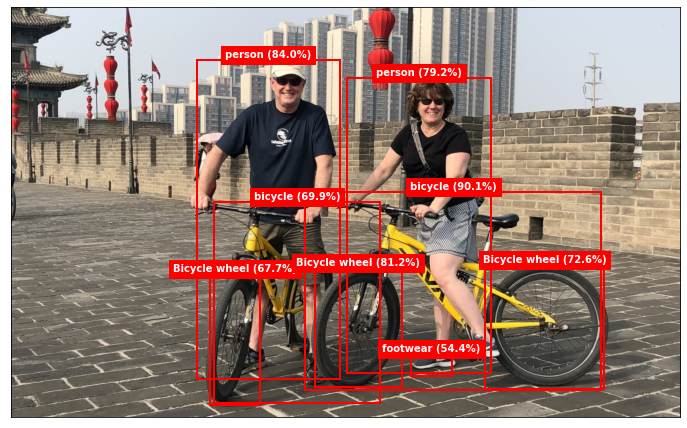

In [4]:
from matplotlib.patches import Rectangle

def annotate_object(name, confidence, bbox, min_confidence=0.5):
    if (confidence > min_confidence):
        x, y, w, h = bbox.x, bbox.y, bbox.w, bbox.h
        rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
        ax.add_patch(rect)
        text = f'{name} ({confidence:.1%})'
        ax.text(x + (w / 2), y, text, color='white', backgroundcolor='red',
                ha='center', va='bottom', fontweight='bold', bbox=dict(color='red'))

image = plt.imread('Data/xian.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
        
with open('Data/xian.jpg', mode='rb') as image:
    result = client.detect_objects_in_stream(image)
    
    for object in result.objects:
        annotate_object(object.object_property, object.confidence, object.rectangle)

Can the Computer Vision service detect faces in photos, too? It certainly can. It can also provide information about age and gender. The following example annotates the faces in a photo with labels denoting age and gender. The `ComputerVisionClient` class lacks a dedicated method for detecting faces, but you can call the general-purpose [`analyze_image_in_stream`](https://docs.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-computervision/azure.cognitiveservices.vision.computervision.operations.computervisionclientoperationsmixin?view=azure-python#azure-cognitiveservices-vision-computervision-operations-computervisionclientoperationsmixin-analyze-image-in-stream) method with a `visual_features` parameter requesting facial info:

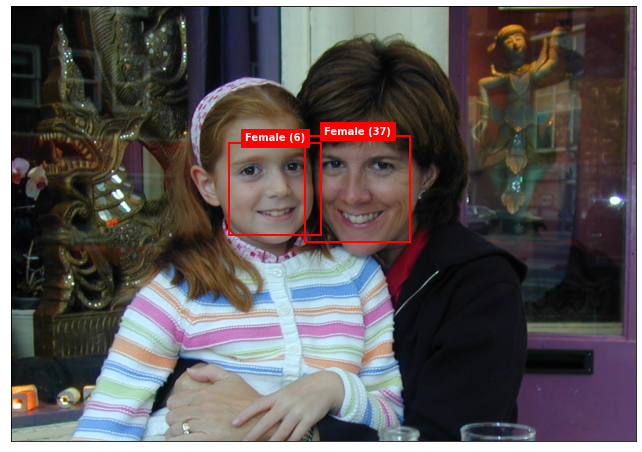

In [5]:
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes

def annotate_face(face):
    x, y = face.face_rectangle.left, face.face_rectangle.top
    w, h = face.face_rectangle.width, face.face_rectangle.height
    rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)
    text = f'{face.gender} ({face.age})'
    ax.text(x + (w / 2), y, text, color='white', backgroundcolor='red', ha='center',
            va='bottom', fontweight='bold', bbox=dict(color='red'))

image = plt.imread('Data/amsterdam.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

with open('Data/amsterdam.jpg', mode='rb') as image:
    result = client.analyze_image_in_stream(image,
             visual_features=[VisualFeatureTypes.faces])

    for face in result.faces:
        annotate_face(face)

Suppose you're the proprietor of a public Web site that accepts photo uploads and you’d like to reject photos containing inappropriate content. Called as follows, `analyze_image_in_stream` scores a photo for adultness (does the photo contain nudity?), raciness (does it contain bare skin?), and goriness (does it contain blood and gore?) on a scale of 0.0 to 1.0. Here’s how it responds to a photo of my daughter cliff-jumping in her bathing suit in Hawaii:

Adultness: 0.02214682288467884
Raciness: 0.4205133616924286
Goriness: 0.0016634466592222452
Is adult: False
Is racy: False
Is gory: False


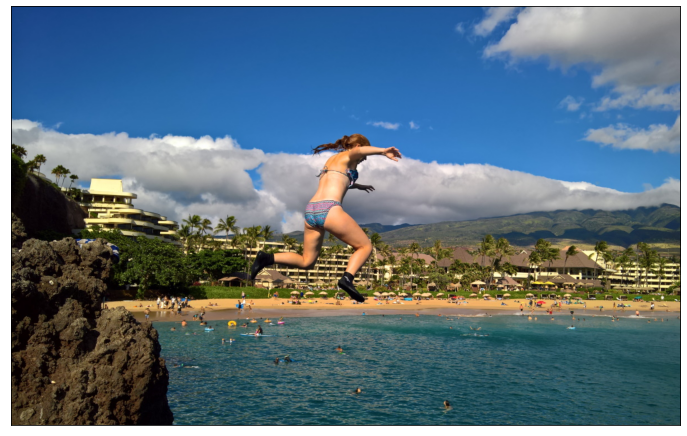

In [6]:
image = plt.imread('Data/maui.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

with open('Data/maui.jpg', mode='rb') as image:
    result = client.analyze_image_in_stream(image,
             visual_features=[VisualFeatureTypes.adult])

    print(f'Adultness: {result.adult.adult_score}')
    print(f'Raciness: {result.adult.racy_score}')
    print(f'Goriness: {result.adult.gore_score}')
    
    print(f'Is adult: {result.adult.is_adult_content}')
    print(f'Is racy: {result.adult.is_racy_content}')
    print(f'Is gory: {result.adult.is_gory_content}')

The bikini in the photo yielded a moderate raciness score, but one that’s below the threshold of 0.5 required for `is_racy_content` to be `True`. Based on the other scores it returned, the Computer Vision service believes that the photo is neither "adult" nor gory.

Yet another capability that the Computer Vision service lends to application developers is using AI to extract text from photos. It’s perfect for digitizing printed documents. Here’s an example:

1040-ES
20
22 Estimated Tax
o Department of the Treasury
U- Internal Revenue Service
File only if you are making a payment of estimated tax by check or money order. Mail this
voucher with your check or money order payable to "United States Treasury." Write your
social security number and "2022 Form 1040-ES" on your check or money order. Do not send
cash. Enclose, but do not staple or attach, your payment with this voucher.
4
Payment
Voucher
OMB No. 1545-0074
Calendar year—Due Jan. 17, 2023
Amount of estimated tax you are paying
by check or
money order.
loo
0
Your first name and middle initial
If joint payment, complete for spouse
Spouse's first name and middle initial
Address (number, street, and apt. no.
Your last name
Spouse's last name
City, town, or post office. If you ha e a foreign address, also complete spaces below.
State
Foreign country name
Foreign province/county
For Privacy Act and Paperwork Reduction Act Notice, see instructions.
Your social security number
Spouse's social

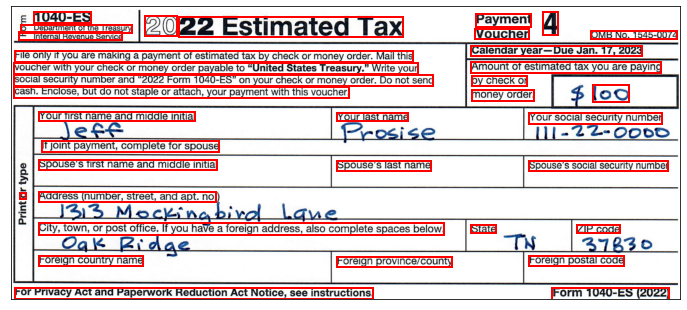

In [7]:
def draw_box(bbox):
    vals = bbox.split(',')
    x = int(vals[0])
    y = int(vals[1])
    w = int(vals[2])
    h = int(vals[3])
    rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)

image = plt.imread('Data/1040-es.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

with open('Data/1040-es.jpg', mode='rb') as image:
    result = client.recognize_printed_text_in_stream(image)
    
    for region in result.regions:
        for line in region.lines:
            text = ' '.join([word.text for word in line.words])
            draw_box(line.bounding_box)
            print(text)

[`recognize_printed_text_in_stream`](https://docs.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-computervision/azure.cognitiveservices.vision.computervision.operations.computervisionclientoperationsmixin?view=azure-python#azure-cognitiveservices-vision-computervision-operations-computervisionclientoperationsmixin-recognize-printed-text-in-stream) only recognizes printed text. A related method named [`read_in_stream`](https://docs.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-computervision/azure.cognitiveservices.vision.computervision.operations.computervisionclientoperationsmixin?view=azure-python#azure-cognitiveservices-vision-computervision-operations-computervisionclientoperationsmixin-read-in-stream) recognizes handwritten text, too. Let's see how it performs on the same scanned document. This example is a little more involved because `read_in_stream` returns before the call has completed. We therefore loop until the call completes and then retrieve the results. The call to `sleep` in each iteration of the `while` loop allows the user interface to remain responsive while waiting for the call to complete

1040-ES
2022 Estimated Tax
Payment
4
Department of the Treasury
Voucher
Internal Revenue Service
OMB No. 1545-0074
Form
File only if you are making a payment of estimated tax by check or money order. Mail this
Calendar year-Due Jan. 17, 2023
voucher with your check or money order payable to "United States Treasury." Write your
Amount of estimated tax you are paying
social security number and "2022 Form 1040-ES" on your check or money order. Do not send
by check or
cash. Enclose, but do not staple or attach, your payment with this voucher.
money order.
$ 100
Your first name and middle initial
Jeff
Your last name
Prosise
Your social security number
111-22-0000
If joint payment, complete for spouse
Spouse's first name and middle initial
Spouse's last name
Spouse's social security number
Address (number, street, and apt. no.)
1313 Mockingbird Lane
City, town, or post office. If you have a foreign address, also complete spaces below.
State
ZIP code
Print or type
Oak Ridge
TN
37830
Foreign c

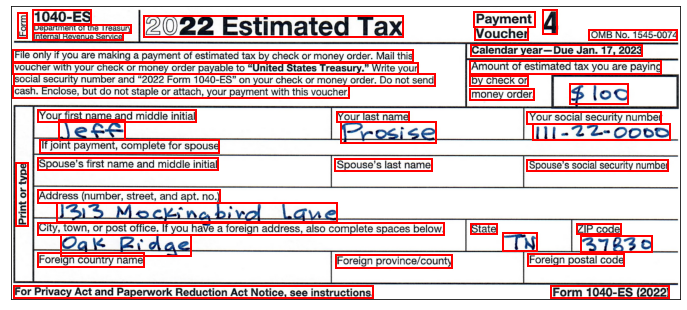

In [8]:
import time
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes

def draw_box(bbox):
    x, y  = bbox[0], bbox[1]
    w = bbox[4] - x
    h = bbox[5] - y
    rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)

image = plt.imread('Data/1040-es.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

with open('Data/1040-es.jpg', mode='rb') as image:
    response = client.read_in_stream(image, raw=True)
    
    location = response.headers["Operation-Location"]
    opid = location[len(location) - 36:]
    results = client.get_read_result(opid)
    
    while results.status == OperationStatusCodes.running:
        results = client.get_read_result(opid)
        time.sleep(1)
        
    if results.status == OperationStatusCodes.succeeded:
        for result in results.analyze_result.read_results:
            for line in result.lines:
                draw_box(line.bounding_box)
                print(line.text)

Perhaps you'd prefer to extract *only* handwritten text from a document. You can do that, too, because for each line of text it detects, `read_in_stream` includes a `style` attribute equal to "handwriting" for handwritten text. Here's an example:

$ 100
Jeff
Prosise
111-22-0000
1313 Mockingbird Lane
Oak Ridge
TN
37830


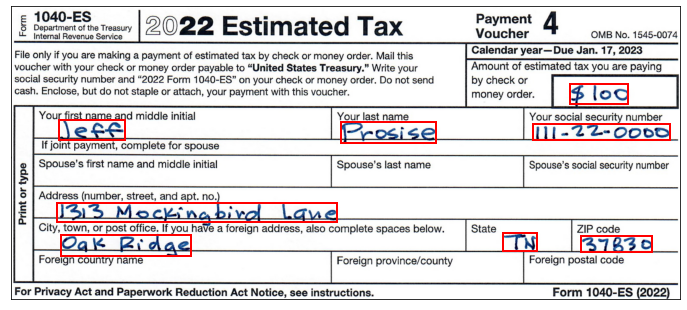

In [9]:
image = plt.imread('Data/1040-es.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

with open('Data/1040-es.jpg', mode='rb') as image:
    response = client.read_in_stream(image, raw=True)
    
    location = response.headers["Operation-Location"]
    opid = location[len(location) - 36:]
    results = client.get_read_result(opid)
    
    while results.status == OperationStatusCodes.running:
        results = client.get_read_result(opid)
        time.sleep(1)
        
    if results.status == OperationStatusCodes.succeeded:
        for result in results.analyze_result.read_results:
            for line in result.lines:
                if (line.appearance.style.name == 'handwriting'):
                    draw_box(line.bounding_box)    
                    print(line.text)

A final note regarding the Computer Vision service is that it doesn’t accept images larger than 4 MB. Anything larger produces a `ComputerVisionErrorResponseException`. You can catch these exceptions (or `AzureError` exceptions, which are higher up the food chain) and recover gracefully, or you can check an image’s size before submitting it and downsize it if necessary.